## Autoencoder Neural Network:
- Unsupervised learning algorithm
- Sets the target value to be equal to the inputs
- Uses one hidden layer
- Tries to learn the function $h_{W,b}(x)=x$
- For small hidden units, the network will be forced to learn compressed representation of the input.
- autencoder often ends up learning a low-dimensional representation very similar to PCA (for hidden units smaller than the input units). 
-  Links for helpful sources:
    - [Notes](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
    - [Code](https://triangleinequality.wordpress.com/2014/08/12/theano-autoencoders-and-mnist/)

In [103]:
import numpy as np
from theano import function, shared, config
import theano.tensor as T
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import gzip
import os
import sys
import time
from numpy import random as rng

In [104]:
def load_data(dataset):
    print("....... LOADING DATA.....")
    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pickle.load(f, encoding="bytes")
    f.close()
    print(train_set[0].shape)
    return (train_set, valid_set, test_set)

<img src="Autoencoder636.png" width="300" height="300">
[Link for the source:](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)

In [30]:
class AutoEncoder(object):

    def __init__(self, input, hiddenDim):
    
        self.input = input
        self.input=shared(name='input', value=np.asarray(self.input, 
                         dtype=config.floatX),borrow=True)
        
        
        self.m = input.shape[0]
        self.n = input.shape[1]
        
        self.hidden_size=hiddenDim
        
        w = np.asarray(rng.uniform(-0.02,0.02, 
                        size=(self.n, self.hidden_size)), dtype=config.floatX)
        self.W = shared(value=w, name='W', borrow=True)
        
        self.b1 = shared(name='b1', value=np.zeros(shape=(self.hidden_size,),
                            dtype=config.floatX),borrow=True)
        
        self.b2 = shared(name='b2', value=np.zeros(shape=(self.n,),
                            dtype=config.floatX),borrow=True)
        
        self.hidden = shared(name='hidden', value=np.zeros(shape=(self.hidden_size,), 
                         dtype=config.floatX),borrow=True)
        

    def train(self, n_epochs=100, mini_batch_size=1, learning_rate=0.1):
        index = T.lscalar()
        x=T.matrix('x')
        
        hidden = T.nnet.sigmoid(T.dot(x, self.W)+self.b1)
        output = T.dot(hidden,T.transpose(self.W))+self.b2
        output = T.nnet.sigmoid(output)
        
        #cross-entropy cost
        L = -T.sum(x*T.log(output) + (1-x)*T.log(1-output), 
                   axis=1)
        cost = L.mean()
        
        # gradient descent
        g_W = T.grad(cost=cost, wrt=self.W)
        g_b1 = T.grad(cost=cost, wrt=self.b1)
        g_b2 = T.grad(cost=cost, wrt=self.b2)

        updates=[]
        updates = [(self.W, self.W - learning_rate * g_W),
                   (self.b1, self.b1 - learning_rate * g_b1),
                   (self.b2, self.b2 - learning_rate * g_b2)]
        
        #Train given a mini-batch of the data.
        train = function(inputs=[index], outputs=[cost], updates=updates,
                            givens={x:self.input[index:index+mini_batch_size,:]})
        
        
        start_time = time.clock()
        for epoch in range(n_epochs):
            print("Epoch:",epoch)
            for row in range(0,self.m, mini_batch_size):
                train(row)
        end_time = time.clock()
        print("Average time per epoch=", (end_time-start_time)/n_epochs)
        
    def get_hidden_data(self):
        x = T.dmatrix('x')
        w = T.dmatrix('w')
        b = T.dvector('b')
        hidden = T.nnet.sigmoid(T.dot(x, self.W)+self.b1)
        hidden_outputs = function(inputs=[], outputs=hidden, 
                                 givens={x:self.input})
        return hidden_outputs()
    
    def get_weights(self):
        return [self.W.get_value(), self.b1.get_value(), self.b2.get_value()]

In [85]:
def training(data):
    X=data
    X = X[:1000,:]
    print(X.shape)
    A = AutoEncoder(X, 500)
    #A = AutoEncoder(X, 50)
    A.train(10,10)
    
    print('weights', np.array(A.get_weights()).shape)
    # save the best model
    with open('best_weights.pkl', 'wb') as f:
        pickle.dump(A.get_weights(), f)
    with open('hidden_outputs.pkl', 'wb') as f:
        pickle.dump(A.get_hidden_data() , f)
        
    W=np.transpose(A.get_weights()[0])
    print(W.shape)
    view_digit_images(10, W)

In [70]:
def view_digit_images(number_of_images, dataset):
    m = (number_of_images - 1)//5 + 1 
    X = dataset
    X = X[:number_of_images,:]
    print('view : ', X.shape)
    f, ax = plt.subplots(m, 5)
    plt.gray()
    i = 0
    j = 0
    for idx in range(X.shape[0]):
        digit = X[idx, :]
        if m > 1:
            ax[i][j].imshow(digit.reshape(28,28))
            ax[i][j].axis('off')
        else:
            ax[j].imshow(digit.reshape(28,28))
            ax[j].axis('off')
        j = j+1
        if(j==5):
            j = 0
            i = i+1
    extra = m*5 -(i*5+j) 
    if extra > 0:
        for axs in range(extra):
            f.delaxes(ax[-1,-axs-1]) 
    plt.show()

In [101]:
def reconstruct(data):
    x = T.dmatrix('x')
    w = T.dmatrix('W1')
    b1 = T.dvector('b1')
    b2 = T.dvector('b2')

    # load the saved model and hidden data for reconstruction
    W = pickle.load(open('best_weights.pkl', 'rb'))
    
    if data is None:
        # reconstructing the training data
        hidden = pickle.load(open('hidden_outputs.pkl', 'rb'))
    else: #case for test or validation data
        #load test data
        X = data
        X = X[:10,:]
        # reconstructing 
        hidden_output = T.nnet.sigmoid(T.dot(x, w)+b1)
        hidden_layer = function(
            inputs=[x, w, b1],
            outputs=hidden_output)
        hidden = hidden_layer(X, W[0], W[1])
   
    hidden = hidden[:10,:] #This is only for debugging. Use full hidden data
    print('hidden :', np.array(hidden).shape)
    
    output = T.dot(x,T.transpose(w))+b2
    
    # compile a predictor function
    reconstruct_model = function(
        inputs=[x, w, b2],
        outputs=output)
               
    output = reconstruct_model(hidden, W[0], W[2])
    print('output :', np.array(output).shape)

    print('........reconstruction .......') 
    view_digit_images(10, output)

In [98]:
def main(argv = None):
    training_set, validation_set, testing_set = load_data('mnist.pkl.gz')
    if argv is 'training':
        data = training_set[0]
        print('main: ', np.array(data).shape)
        training(data)
    elif argv is 'reconstruct':
        data = training_set[0]
        print('main: ', np.array(data).shape)
        view_digit_images(10, data)
        training(data)
        reconstruct(None)
    elif argv is 'testing':
        data = testing_set[0]
        view_digit_images(10, data)
        print('main: ', np.array(data).shape)
        reconstruct(data)
    else:
        data = training_set[0]
        view_digit_images(10, data)

....... LOADING DATA.....
(50000, 784)
view :  (10, 784)


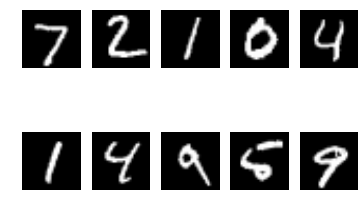

main:  (10000, 784)
hidden : (10, 500)
output : (10, 784)
........reconstruction .......
view :  (10, 784)


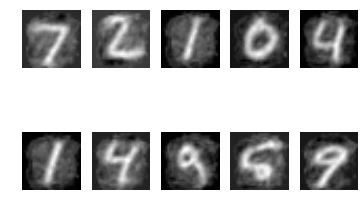

In [108]:
if __name__ == "__main__":
    main('testing')